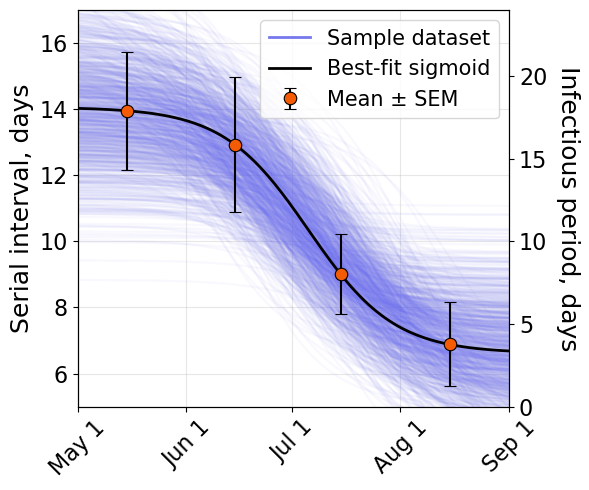

t0 (inflection) ≈ 2022-07-06
t0     = 48.851 ± 13.678
TSmax     = 14.057 ± 1.637
TSmin  = 6.612 ± 1.483


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.lines import Line2D
from scipy.optimize import curve_fit
from datetime import date, timedelta

# 0) make sure import_date is defined first
import_date = date(2022, 5, 19)

# 1) month‐ticks (5 points)
months      = ['May 1','Jun 1','Jul 1','Aug 1','Sep 1']
month_dates = [pd.Timestamp(f"2022-{m.split()[0]}-01") for m in months]
x_ticks     = np.array([(dt.date() - import_date).days + 1 for dt in month_dates])  # length 5

# 2) SI measurement days (4 points)
SI_dates        = [date(2022, 5, 15),
                   date(2022, 6, 15),
                   date(2022, 7, 15),
                   date(2022, 8, 15)]
x_values_fit    = np.array([(d - import_date).days + 1 for d in SI_dates])          # length 4

# Data
N    = np.array([41, 31, 34, 15])
mean = np.array([13.95, 12.92, 9.00, 6.88])
sd   = np.array([11.39, 11.39, 7.07, 4.93]) / np.sqrt(N)

k = 2.5 / 30.5

def sigmoid3(x, t0, TSmax, TSmin):
    return TSmax - (TSmax - TSmin) / (1 + np.exp(-k*(x - t0)))

# 3) Fit on the 4‐point SI data
p0 = [7, 14, 7]   # t0_guess (days), TSmax_guess, TSmin guess
params, cov = curve_fit(
    sigmoid3,
    x_values_fit,
    mean,
    p0=p0,
    sigma=sd,
    absolute_sigma=True
)
t0_hat, TSmax_hat, TSmin_hat = params
# right after you get params, cov
errs = np.sqrt(np.diag(cov))    # three 1-σ uncertainties
t0_err, TSmax_err, TSmin_err = errs

# 4) Plot everything in “days”
fig, ax1 = plt.subplots(1,1,figsize=(6,5))

M = 1000
# sampled curves over the full tick‐range
x_plot = np.linspace(x_ticks.min(), x_ticks.max(), 200)
first = True
for t0_s, TSmax_s, TSmin_s in np.random.default_rng(42).multivariate_normal(params, cov, size=M):
    if first:
        ax1.plot(x_plot,
             sigmoid3(x_plot,t0_s,TSmax_s,TSmin_s),
             color='#7678ed', alpha=0.05,label = "Sample dataset")
        first = False
    else:
        ax1.plot(x_plot,
                 sigmoid3(x_plot,t0_s,TSmax_s,TSmin_s),
                 color='#7678ed', alpha=0.05)

# best‐fit
ax1.plot(x_plot,
         sigmoid3(x_plot, *params),
         'k-', lw=2, label='Best‐fit sigmoid')

ax1.errorbar(
    x_values_fit, mean, yerr=sd,
    fmt='o',                         # circle marker
    markersize=9,                    # adjust size if you like
    markerfacecolor='#f35b04',       # fill color
    markeredgecolor='black',         # edge color
    markeredgewidth=0.8,             # edge line width
    capsize=4,
    ecolor='k',
    elinewidth=1.5,
    label='Mean ± SEM'
)

labelsize   = 18
ticksize    = 16
legendsize  = 15
# tick labels at the 5 month‐ticks
ax1.set_xticks(x_ticks)
ax1.set_yticks([6,8,10,12,14,16,18])
ax1.set_yticklabels([6,8,10,12,14,16,18],fontsize = ticksize)
ax1.set_xticklabels(months, rotation=45, fontsize=ticksize)
ax1.set_ylabel('Serial interval, days', fontsize=labelsize)
ax1.margins(x=0) 
ax1.grid(alpha=0.3)
ax1.legend(loc='upper right', fontsize=legendsize)


# -- Secondary axis for TI -----------------------------
TE = 5  # given constant
def TS_to_TI(TS): return 2 * (TS - TE)

ax2 = ax1.twinx()
# Force the left‐hand (TS) axis to run from –1 to +10
ax1.set_ylim(5, 17)
# And map those exact same endpoints through your TS→TI conversion
ax2.set_ylim(TS_to_TI(4), TS_to_TI(16))

ymin, ymax = ax1.get_ylim()
ax2.set_ylim(TS_to_TI(ymin), TS_to_TI(ymax))
#ax2.set_ylabel('Infectious period, days', fontsize=14)
ax2.set_ylabel(
    'Infectious period, days',
    fontsize=labelsize,
    rotation=270,       # rotate so the bottom of each letter points left
    labelpad=15,        # you may need to tweak this so the text doesn’t butt up against the plot
    va='center'         # keep it centered along the y‐axis
)
ax2.tick_params(axis='y', labelsize=ticksize)
ax2.yaxis.set_major_locator(mticker.MultipleLocator(5))
ax2.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))

# 1) build a proxy artist to make a legend symbol with separate alpha-value
proxy_sample = Line2D(
    [0], [0],
    color='#7678ed',    # same color as your α=0.05 curves
    lw=2,               # or whatever linewidth you like
    alpha=1.0           # fully opaque in the legend
)

# 2) grab the existing handles/labels for the best‐fit sigmoid and errorbars:
orig_handles, orig_labels = ax1.get_legend_handles_labels()

# 3) now re‐make the legend, replacing the first handle (the faint α=0.05 line)
#    with our opaque proxy_sample. Adjust indices if your label order differs.
new_handles = [proxy_sample] + orig_handles[1:]
new_labels  = ['Sample dataset'] + orig_labels[1:]

ax1.legend(
    handles=new_handles,
    labels=new_labels,
    loc='upper right',
    fontsize=legendsize
)

plt.tight_layout()
plt.show()

# inflection‐date
t0_date = import_date + timedelta(days=t0_hat)
print(f"t0 (inflection) ≈ {t0_date}")
# Print results
print(f"t0     = {t0_hat:.3f} ± {t0_err:.3f}")
print(f"TSmax     = {TSmax_hat:.3f} ± {TSmax_err:.3f}")
print(f"TSmin  = {TSmin_hat:.3f} ± {TSmin_err:.3f}")